# Banglore home prices analysis

REF: https://www.youtube.com/watch?v=rdfbcdP75KI&list=PLeo1K3hjS3uu7clOTtwsp94PcHbzqpAdg&index=1

### A simple end to end project:

- Data cleaning and formating
- Exploratory analysis
- Feature engineering and imputation
- Model training and evaluation
- Build a web server with Flask that consumes predictions from the trained model, and a UI (client) with css, html, and js that makes http POST and GET calls to the web server
- Similar to the Zillow Zestimate feature

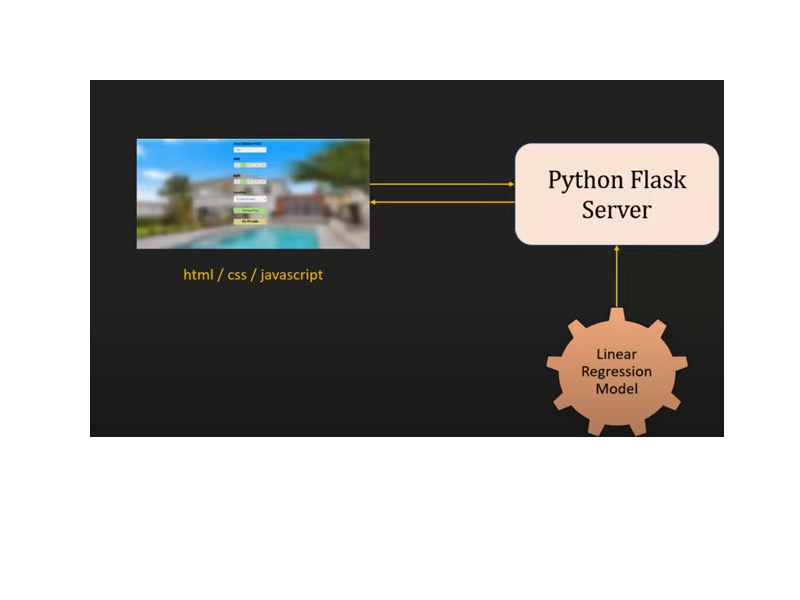

In [1]:
import sys
import os
from pathlib import Path
import re

'''data'''
import pandas as pd
import numpy as np

'''visualization'''
import matplotlib.pyplot as plt
import seaborn as sns

'''sklearn'''
from sklearn.model_selection import ShuffleSplit,StratifiedShuffleSplit
from sklearn.preprocessing import Binarizer


'''feature engine'''
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import RareLabelEncoder

In [2]:
# Set working directory 
try: INIT_RUN
except NameError:
    os.chdir(os.path.dirname(os.getcwd()))
    INIT_RUN=True

## Project Config

In [3]:
ROOT_DIR = os.getcwd()
RAW_DATA_DIR = Path(ROOT_DIR,"home_price_analysis","datasets","raw")
RAW_DATA_FILE = "house_prices.csv"

RANDOM_STATE= 10
TEST_SIZE = 0.2


OUTCOME_VARIABLE = "price"
NUM_BEDROOM_RETAIN=8
AREA_TYPE_RETAIN = 2
FEATURES_TO_DROP=["society"]

SQFT_PER_SQ_METER= 10.764
SQFT_PER_SQ_YARD= 9.0

## Helper functions

In [4]:
def load_housing_data(raw_data_path: object = RAW_DATA_DIR) -> pd.DataFrame:
    '''
    This function searches for raw data csv file and imports it as a pandas DataFrame
    
    Args:
        raw_data_path (PosixPath): data path object to the raw data csv
    
    Returns:
        pd.DataFrame    
    '''
    # If raw data directory does not exist, I will make one
    if not os.path.isdir(raw_data_path):
        os.makedirs(raw_data_path)
    
    # import raw data as pd.DataFrame
    try:
        data = pd.read_csv(Path(RAW_DATA_DIR,RAW_DATA_FILE))
    except ImportError:
        "Fail to import raw data file."
        
    return data

In [5]:
def process_total_sqft(input_str:str)->float:
    '''
    This function processes the total_sqft column (perform unit conversion, reformats values
    and averages total_sqft ranges)
    Args:
        input_str (PosixPath): data path object to the raw data csv
    
    Returns:
        processed value for total_sqft (float)    
    '''
    
    # search to see if input string has "-"
    if re.search("-", input_str):
        # Get a list of the ranges
        str_list = input_str.split(" - ")        
        # Convert the list from string to float
        num_list = np.array([float(i) for i in str_list])
        # Compute the average of the two ranges
        return num_list.mean()
    
    # search to see if input string has "Sq. Meter"
    elif re.search("Sq. Meter", input_str):
        pattern=r"Sq. Meter"
        # remove "Sq.Meter", convert from string to float, and then convert to sq-ft
        return SQFT_PER_SQ_METER * float(re.sub(pattern, '', input_str))
    
    elif re.search("Sq. Yards", input_str):
    # search to see if input string has "Sq. Yards"
        pattern=r"Sq. Yards"
        # remove "Sq. Yards", convert from string to float, and then convert to sq-ft
        return SQFT_PER_SQ_YARD * float(re.sub(pattern, '', input_str))
    
    else:
        return np.nan

In [6]:
def remove_outlier(df_in, col_name, lwr_bound =None, upr_bound=None):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    
    if lwr_bound is None:
        lwr_bound  = q1-1.5*iqr
    
    if upr_bound is None:
        upr_bound = q3+1.5*iqr
    
    df_out = df_in.loc[(df_in[col_name] > lwr_bound) & (df_in[col_name] < upr_bound)]
    return df_out

## Main project

## Import data

In [7]:
data = load_housing_data()

In [8]:
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [9]:
data.shape

(13320, 9)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


**The data has a small number of observations; however, there are only 8 features and 1 outcome variable. So the number of features is small relatively to the number of observations. There is no risk of overfitting and I probably do not need dimensionality reduction. There is a mix of categorical variable (some ordinal like "size", others are nominal like "area type" and "location") and continuous variable (total_sqft, bath). Several variables have missing values-- society has the most (5503, so close to a third).** 

In [11]:
data.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


**There could be some outliers-- there is one house with 40 baths**

In [12]:
data.describe(include=["O"])

,area_type,availability,location,size,society,total_sqft
count,13320,13320,13319,13304,7818,13320
unique,4,81,1305,31,2688,2117
top,Super built-up Area,Ready To Move,Whitefield,2 BHK,GrrvaGr,1200
freq,8790,10581,540,5199,80,843


**Lots of levels for avaialbility (date?) and location. We might binarize availability to "ready to move" and "not ready to move", and factor lump location and society.
Size could be an open response (I see 2 BHK and 2 bedroom). totl_sqft should be a numeric value (need to deal with NA)**

**Let's take a look at the distribution of log price**

## Train test split
- REF: geeksforgeeks.org/sklearn-stratifiedshufflesplit-function-in-python/
- REF2: https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn
- REF3: https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

### Notes:
- We do this early on so that we only do exploratory analysis with the train set
- We will transform the test data once we create a data pipeline
- StratifiedShuffleSplit is a combination of ShuffleSplit and StratifiedKFold.
- StratifiedKfold: performs stratified sampling and k-fold cross validation:
    - Stratified sampling preserves the distribution of the outcome variable or a selected feature (from the entire dataset) for both the train and test set. It is usually used for classification problem where the overall dataset is divided into stratas (homogeneous groups), and the "right" number of instances is sampled from each strata to guarantee the train set and the test set are both representative of the overall dataset. In classification problems with outcome variables that has imbalanced class, we use the levels of the outcome variable as the strata. In regression problems, we might choose an important categorical feature based on domain experts or theory (e.g., income_category) and use its level as the strata.
    - StratifiedKfold: one problem with just using train_test_split with random seed, or stratify sampling is that depending on what random seed that I choose, my test accuracy score (estimated using the validation set approach) might be higher or lower. The solution is to use k-fold cross validation (which I can do using cross_val_score). 
    - An alternative way is to use StratifiedKfold, which basically shuffles the overall data (using np.random as default) and sampling this data (with no replacement) to create k-folds of the overall dataset. 9 folds (combined together) will be used as the train set and 1 fold will be used for the test sets. Thus, the output of StratifiedKfold is 10 sets of train indices and test indices. 
    - Let's take a look a ONE particular set of train and test indices and think about what they are: the train indices will be the indices of the observations in 9 of the 10 folds, and the test indices are indices of the observations in 1 of the 10 folds. The second set of train and test indices would be the same, except this time a different fold is used as the test set.
    - I will train model (regr.fit()) using the train set and compute the accuracy score using the test set. I repeat this 10 times for each set of train & test sets. I will get 10 test accuracy score, and I can take the mean to get the overall CV accuracy score.
    - StratifiedShuffleSplit: same as StratifedKFold except the overall data is shuffled each time before sklearn samples from the overall dataset to create a fold. Note that sklearn will sample with replacement (draws from the shuffled overall dataset each time to create a fold). That's why a data instance might appear in one or more folds.

In [13]:
# init the split object
split = ShuffleSplit(n_splits=1,
                     test_size=TEST_SIZE,
                     random_state=RANDOM_STATE)

In [14]:
# Only 1 fold was done since set "n_splits" to 1.
# We shuffle the overall dataset, and then draw 0.8 of the sample to the train set and 0.2 to the test set
for train_index, test_index in split.split(X=data):
    print(f"{train_index}, {test_index}") # we only have one set of train and test index since we only have 1 fold
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

[ 3875  7004  6286 ... 12815  7293  1289], [  76 5487 5195 ... 2167 6004 4707]


In [15]:
housing = train_set.copy() # Make a copy of the train set for us to work with
housing.shape

(10656, 9)

## Exploratory analysis

**The distribution of price**

In [16]:
housing

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
3875,Super built-up Area,18-Aug,Kengeri Satellite Town,3 BHK,DSestSt,1149,2.0,2.0,29.00
7004,Super built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1255,2.0,3.0,50.19
6286,Plot Area,18-Aug,Whitefield,2 Bedroom,NaN,1200,2.0,1.0,46.13
2887,Super built-up Area,Ready To Move,Haralur Road,3 BHK,RBersll,1850,3.0,NaN,110.00
7746,Super built-up Area,Ready To Move,8th Phase JP Nagar,2 BHK,NaN,1100,2.0,3.0,35.00
...,...,...,...,...,...,...,...,...,...
11633,Super built-up Area,Ready To Move,HSR Layout,3 BHK,PuontFa,1590,2.0,2.0,135.00
1344,Super built-up Area,Ready To Move,Rukmaiah Layout,3 BHK,NaN,1655,3.0,2.0,86.06
12815,Super built-up Area,Ready To Move,Kodichikkanahalli,2 BHK,NaN,900,2.0,1.0,35.00
7293,Built-up Area,Ready To Move,Kengeri,2 BHK,Sravema,1230,2.0,2.0,45.00


<AxesSubplot:>

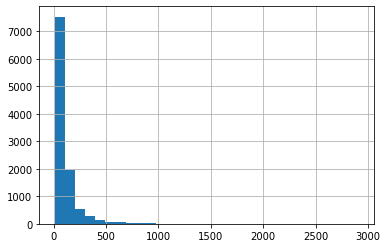

In [17]:
housing["price"].hist(bins=30)

**I need to log transform price to bring high/low prices together and spread small prices that are close togeher further out. NOTE: I usually only transform the response variable if non-normal error or non-common Var(u) are the ONLY problems.** 

!!TF!!

In [18]:
# save a copy of the original "price" column before log transformation
housing["orig_price"] = housing["price"]

In [19]:
log_tf= LogTransformer(variables = ['price'])
housing=log_tf.fit_transform(housing)

<AxesSubplot:>

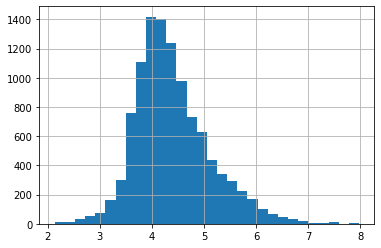

In [20]:
housing["price"].hist(bins=30)

## Categorical variables

In [21]:
cat_vars = [var for var in housing.columns if housing[var].dtype=="O"]
cat_vars

['area_type', 'availability', 'location', 'size', 'society', 'total_sqft']

### size (number of bedrooms)

In [22]:
housing["size"].unique()

array(['3 BHK', '2 Bedroom', '2 BHK', '1 BHK', '4 Bedroom', '3 Bedroom',
       '7 BHK', '4 BHK', '8 Bedroom', '6 Bedroom', '6 BHK', '5 BHK',
       '5 Bedroom', '1 Bedroom', nan, '9 Bedroom', '1 RK', '7 Bedroom',
       '9 BHK', '11 BHK', '10 Bedroom', '10 BHK', '8 BHK', '11 Bedroom',
       '12 Bedroom', '14 BHK', '16 BHK', '18 Bedroom', '13 BHK', '27 BHK'],
      dtype=object)

In [23]:
housing["size"].isna().sum()/(len(housing)) # size has a very small number of missing values, let's just drop them

0.0014076576576576576

In [24]:
housing.dropna(subset="size", inplace=True)

In [25]:
housing.shape

(10641, 10)

In [26]:
# Let's remove the "BNK" and "Bedroom" and only retain the numeric value. 
# We will then convert size to a numeric variable
# Extract the first one or more digits and then set column to integer
housing["size"]=(housing["size"]
 .str.extract(r'(\d+)')
 .astype(float))

In [27]:
housing["size"].value_counts()

2.0     4421
3.0     3914
4.0     1118
1.0      514
5.0      289
6.0      169
7.0       79
8.0       75
9.0       44
10.0       8
11.0       4
12.0       1
14.0       1
16.0       1
18.0       1
13.0       1
27.0       1
Name: size, dtype: int64

In [28]:
# Remove outliers in size
housing = remove_outlier(housing,"size")

**I remove the 15 missing values, remove the BHK/Bedroom text, and then remove the outliers and convert the variable to int64**

In [29]:
housing.shape

(9967, 10)

### Area and society

In [30]:
housing["location"].value_counts()

Whitefield                          428
Sarjapur  Road                      311
Electronic City                     255
Kanakpura Road                      221
Thanisandra                         181
                                   ... 
Bilal Nagar                           1
Neelasandra                           1
J P Nagar 7th Phase Ramayya City      1
Thirupalya                            1
Rukmaiah Layout                       1
Name: location, Length: 1112, dtype: int64

In [31]:
housing["society"].value_counts()

GrrvaGr    65
PrarePa    59
Sryalan    52
GMown E    47
Prtates    47
           ..
SocusHi     1
Vaw 2il     1
Sie 2is     1
Apntsal     1
Vaeva E     1
Name: society, Length: 2317, dtype: int64

!!TF!!

In [32]:
# drop society
drop_features_tf = DropFeatures(features_to_drop= FEATURES_TO_DROP)
housing=drop_features_tf.fit_transform(housing)

**Society both have 2333 levels. I don't really have domain knowledge on this variable to meaningfully reduce its level (e.g. by binning). For this reason, I will exclude it from my models.**  

### area_type

In [33]:
housing["area_type"].isnull().sum()

0

In [34]:
housing["area_type"].value_counts()

Super built-up  Area    6977
Built-up  Area          1807
Plot  Area              1120
Carpet  Area              63
Name: area_type, dtype: int64

**I will retain the top 2 levels and combine plot area and carpet area as "Other"**

In [35]:
# get top n (I will retain n levels) and lump the rest to Other
topn=(housing["area_type"]
    .value_counts(sort=True)
    .index[:AREA_TYPE_RETAIN])

housing["area_type"]=(housing["area_type"]
     .where(housing["area_type"].isin(topn),
            "Other")
)

In [36]:
housing["area_type"].value_counts(sort=True, normalize=True)

Super built-up  Area    0.700010
Built-up  Area          0.181298
Other                   0.118692
Name: area_type, dtype: float64

### availability

In [37]:
housing["availability"].isna().sum()

0

In [38]:
housing["availability"].value_counts(sort=True)

Ready To Move    7822
18-Dec            250
18-May            231
18-Apr            207
18-Aug            163
                 ... 
14-Jul              1
16-Jul              1
15-Dec              1
14-Nov              1
15-Jun              1
Name: availability, Length: 78, dtype: int64

**It is difficult to know if the availiability dates are predictive of price. It would have been more useful if we know the elasped time between sale date and availability of the house (for move-in). For this reason, let's just binarize this variable: if house is "Ready to Move", the variable takes on 1, and 0 otherwise.**

!!TF!!

In [39]:
housing["availability"]=(housing["availability"]
 .apply(lambda x: "Ready to move" if (x =="Ready To Move") else "Not ready to move")
 .astype("category"))

In [40]:
housing["availability"].value_counts()

Ready to move        7822
Not ready to move    2145
Name: availability, dtype: int64

### total_sqft

**I expect this to be a numeric value, why is this an object? Are there text in this column?**

In [41]:
housing["total_sqft"].isnull().sum()

0

In [42]:
# find all of the non numeric characters (disregarding space)
mask=(housing["total_sqft"]
 .str.extract(r'([^0-9.])', expand=False)) # return a series
mask.value_counts()

     157
S     21
A      7
G      2
Name: total_sqft, dtype: int64

**There are some elements with blank entry, and others with "." and letters. Let's take a look at these rows**

In [43]:
(housing["total_sqft"]
 .loc[mask.notnull()]
 .unique())

array(['45.06Sq. Meter', '3103 - 3890', '1180 - 1630', '1.26Acres',
       '660 - 670', '2400 - 2600', '167Sq. Meter', '2805 - 3565',
       '38Guntha', '2830 - 2882', '1408 - 1455', '2957 - 3450',
       '1446 - 1506', '361.33Sq. Yards', '1610 - 1880', '934 - 1437',
       '1100Sq. Yards', '1230 - 1490', '598 - 958', '2Acres',
       '2249.81 - 4112.19', '1115 - 1130', '1437 - 1629', '1150 - 1194',
       '540 - 670', '620 - 933', '1520 - 1740', '142.61Sq. Meter',
       '524 - 894', '15Acres', '3010 - 3410', '1270 - 1275',
       '5666 - 5669', '655 - 742', '1564 - 1850', '3630 - 3800',
       '1145 - 1340', '2800 - 2870', '381 - 535', '645 - 936',
       '1000 - 1285', '1565 - 1595', '1255 - 1350', '3425 - 3435',
       '4260 - 4408', '1310 - 1615', '633 - 666', '1100 - 1225',
       '610 - 615', '1804 - 2273', '2650 - 2990', '980 - 1030',
       '1660 - 1805', '2563 - 2733', '1250 - 1305', '942 - 1117',
       '3090 - 5002', '3450 - 3472', '540 - 565', '1Grounds',
       '697Sq. Me

### Handle these cases, and discard the rest:
- XSq. Meter: I will remove "Sq. Meter" and convert the value to square feet 
- Range of two values: I will take the average of the two numbers
- XSq. Yards: I will remove "Sq. Yards" and convert the value to square feet
- Set the rest of the observations with text to NA

In [44]:
# Get a subset of the total_sqft column that contains non-numeric characters
sub_ser=(housing["total_sqft"]
 .loc[mask.notnull()])

In [45]:
# process total_sqft elements that contains non-numeric characters
sub_ser=(sub_ser
     .apply(lambda x:process_total_sqft(x)))

In [46]:
# replace elements in total_sqft with non-numeric characters with the processed data
housing.loc[list(sub_ser.index),'total_sqft'] = sub_ser

In [47]:
# drop all NA in total_sqft, and then convert the column to float
housing["total_sqft"]=(housing
    .total_sqft
    .dropna()
    .astype(float))

In [48]:
housing.total_sqft.dropna().isna().sum()

0

In [49]:
housing.shape

(9967, 9)

In [50]:
# Remove outliers in total_sqft
housing = remove_outlier(housing,"total_sqft")

In [51]:
housing.shape

(9139, 9)

<AxesSubplot:ylabel='Frequency'>

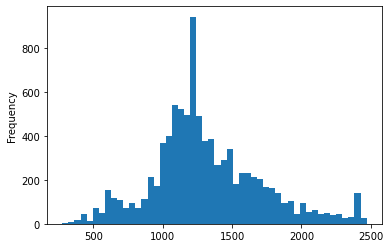

In [52]:
housing["total_sqft"].plot.hist(bins=50)

In [53]:
housing["total_sqft"].describe()

count    9139.000000
mean     1313.009557
std       394.413580
min       276.000000
25%      1083.500000
50%      1240.000000
75%      1530.000000
max      2470.000000
Name: total_sqft, dtype: float64

### Location

In [54]:
housing.location.nunique()

1049

In [62]:
val_counts = housing["location"].value_counts()
keep_locations = val_counts.loc[val_counts>10].index

In [63]:
housing["location"]=(housing["location"]
     .where(housing["location"].isin(keep_locations),
            "Other"))

In [66]:
housing.location.value_counts()

Other                 2369
Whitefield             351
Sarjapur  Road         271
Electronic City        254
Kanakpura Road         213
                      ... 
Basaveshwara Nagar      11
Badavala Nagar          11
Billekahalli            11
Vasanthapura            11
NGR Layout              11
Name: location, Length: 171, dtype: int64

## Removing additional observations that could be erroroneous

**I will remove all houses where the number of bath > number of bedrooms (size)+2 since it is unreasonable for a house to have 2 more bathrooms than bedrooms.**

In [ ]:
housing.dropna(subset=["bath"], inplace=True)

In [ ]:
housing.shape

In [ ]:
housing=housing.loc[housing["bath"]<(housing["size"]+2),:].copy()

**I remove all outliers of price/sqft at each location**

In [ ]:
for key, subdf in housing.groupby("location"):
    print(key)
    print(subdf)

In [ ]:
# Compute price per total sqft
try:
    housing["price_per_total_sqft"] = housing["orig_price"]/housing["total_sqft"]
except ZeroDivisionError:
    print("Cannot divide by zero for price_per_total_sqft!")

In [ ]:
housing.head(5)

In [ ]:
def remove_outlier_pps(df_in):
    # init empty output dataframe
    df_out = pd.DataFrame() 
    # Get dataframe per location group
    for key, df_per_group in df_in.groupby("location"):
        # get group mean and std
        group_mean = np.mean(df_per_group["price_per_total_sqft"])
        group_std = np.std(df_per_group["price_per_total_sqft"])
        # if the absolute standardized price_per_total_sqft is less than 2.5 then keep
        df_reduced=df_per_group.loc[abs(((df_per_group["price_per_total_sqft"]-group_mean)/group_std))<2.5,:]
        
        # populate df_out (row concat)
        df_out = pd.concat([df_out,df_reduced], ignore_index=True)
        
    return df_out

In [ ]:
housing=remove_outlier_pps(housing)

In [ ]:
housing.head()

## EDA on the processed categorical variables

### price X area_type
- Boxplot of price for each area_type categories
- Compute the median price for each area_type categories and create a barplot (use median price so that we will be robust to outliers)

In [ ]:
rank= (housing
          .groupby("area_type")["orig_price"]
          .median()
          .sort_values(ascending=False)
          .index)

In [ ]:
fig = plt.figure(figsize=(10,5))
ax= fig.add_subplot(1,1,1)

ax = sns.boxplot(
    x = "orig_price",
    y = "area_type",
    data=housing,
    order=rank)
ax.set_xlabel("log house prices")


In [ ]:
# Using barplot
sns.barplot(x="orig_price",
            y="area_type",
            estimator=np.median,
            data = housing,
            order = rank)    

**The variance of houses in super built-up area is the highest, and variance of houses in built-up area is the loweest. Other has the highest median price (twice higher than the other two area types) and the median price of houses in built-up area is similar to houses in super built-up area.**

In [ ]:
housing.orig_price

### price vs availability

In [ ]:
fig = plt.figure(figsize=(10,5))
ax= fig.add_subplot(1,1,1)

# Using barplot
ax = sns.barplot(x="orig_price",
            y="availability",
            estimator=np.median,
            data = housing)

**Houses that are "Ready to move in" command a median price than houses not ready to be move in.**

**We can create a variable called "tot_sqft_per_bedroom" = total_sqft/size**

In [ ]:
try:
    housing["tot_sqft_per_bedroom"] = housing["total_sqft"]/housing["size"]
except ZeroDivisionError:
    housing["tot_sqft_per_bedroom"] = np.nan
    print("Cannot divide by zero, set variable to NA!")

### EDA of continuous variables

In [ ]:
# Get numerical variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_vars = list(housing.select_dtypes(include=numerics).columns.values)

In [ ]:
# Use pandas scatter_matrix to plot continuous variables

In [ ]:
pd.plotting.scatter_matrix(housing[num_vars], figsize=(20,10));

In [ ]:
corr_matrix = housing[num_vars].corr()
corr_matrix[["price","orig_price"]].sort_values(ascending=False, by="price")

**From the correlation matrix and the scatterplots, size, bath, total_sqft the numeric variables that are at least moderately correated with price (and log pirce). We will remove balcony and tot_sqft_per_bedroom from the model.**

In [ ]:
selected_features = ["area_type","availability","size","total_sqft","bath"]

## Appendix (Unused code)

In [ ]:
# init the split object
split = StratifiedShuffleSplit(
    n_splits = 1,
    test_size = TEST_SIZE,
    random_state= RANDOM_STATE
)

In [ ]:
# Only 1 fold was done since set "n_splits" to 1.
# We shuffle the overall dataset, and then draw 0.8 of the sample to the train set and 0.2 to the test set
# We preserve the same proportion of area_type for both train and test set as the overall dataset
# X is the overall dataset, 
# y is the variable I want to stratify on (usually it is the outcome 
# variable for classification problems). Can be more than one variable, must be a list.
for train_index, test_index in split.split(X=data, y=data["area_type"]):
    print(f"{train_index}, {test_index}") # we only have one set of train and test index since we only have 1 fold
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [ ]:
strat_test_set["area_type"].value_counts(normalize=True)

In [ ]:
data["area_type"].value_counts(normalize=True)

- XSq. Meter: I will remove "Sq. Meter" and convert the value to square feet 
- Range of two values: I will take the average of the two numbers
- XAcres: I will remove "Acres" and convert the value to square feet
- XSq. Yards: I will remove "Sq. Yards" and convert the value to square feet


In [ ]:
input_str = "1210 - 1477"

In [ ]:
str_list = input_str.split(" - ")

In [ ]:
num_list = np.array([float(i) for i in str_list])

In [ ]:
num_list.mean()

In [ ]:
def process_total_sqft_test(input_str):
    if re.search("-", input_str):
        str_list = input_str.split(" - ")
        num_list = np.array([float(i) for i in str_list])
        return num_list.mean()

In [ ]:
process_total_sqft_test(input_str)

In [ ]:
input_str = "142.61Sq. Meter"

In [ ]:
if re.search("Sq. Meter", input_str):
    print("Yes!")
else:
    print("No!")

In [ ]:
pattern=r"Sq. Meter"
out = float(re.sub(pattern, '', input_str))
out

In [ ]:
def process_total_sqft_test(input_str):
    if re.search("-", input_str):
        str_list = input_str.split(" - ")
        num_list = np.array([float(i) for i in str_list])
        return num_list.mean()
    elif re.search("Sq. Meter", input_str):
        pattern=r"Sq. Meter"
        return float(re.sub(pattern, '', input_str))

In [ ]:
process_total_sqft_test(input_str)

In [ ]:
from collections import OrderedDict

In [ ]:
def replace_all(text, d):
    for i, j in d.items():
        text = text.replace(i, j)
    return text

In [ ]:
test=housing["area_type"].apply(lambda x: replace_all(x, OrderedDict([("  ", " "),(" ", "_"),("-","_")])))

In [ ]:
test.value_counts()

In [ ]:
df_test = pd.DataFrame({"A":[1,5,6,7,7,8,9,30],
                        "B":[2,4,5,3,3,2,1,7]})
df_test

In [ ]:
m = np.mean(df_test["A"])
s = np.std(df_test["A"])
m,s

In [ ]:
df_test["A"]-m

In [ ]:
abs(df_test["A"]-m)

In [ ]:
abs(((df_test["A"]-m)/s))

In [ ]:
abs(((df_test["A"]-m)/s))<2.5

In [ ]:
df_test.loc[abs(((df_test["A"]-m)/s))<2.5,:]